In [1]:
import os
#import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import tensorflow as tf
import random
import PIL
from PIL import Image, ImageOps

os.environ["CUDA_VISIBLE_DEVICES"] = "0"

gpus = tf.config.experimental.list_physical_devices(device_type='GPU')

for gpu in gpus:
    tf.config.experimental.set_memory_growth(device=gpu, enable=True)

len(os.listdir(f'tmp'))  # Directory where training data folders are

196

In [2]:
tf.config.experimental.list_physical_devices(device_type='GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

###  Hyperparameters

batch size 256: 0.798

batch size 128: 0.833

batch size 64: 0.858

batch size 32: 0.881

batch size 16 0.891

In [3]:
batch_size = 4  # Training batch size
num_classes = 196  # Classes in dataset
num_epochs = 51   # Epochs for training   
lr = 1e-3  # Learning rate
lr_weight_decay = 1e-5 # Learning weight decay
IMAGE_SIZE = 600

### Data Processing

In [4]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from albumentations.augmentations.transforms import Posterize, Rotate, Solarize, RandomContrast, Equalize, ColorJitter, InvertImg, Cutout, Normalize
from albumentations.imgaug.transforms import IAASharpen
from albumentations import Compose, OneOf
from cutmix_keras import CutMixImageDataGenerator

# from imgaug import augmenters as iaa

# augmentation = iaa.Sequential([iaa.RandAugment(n=2, m=9)])
# def additional_augmenation(image):
#     image = image.astype('uint8')
#     image = augmentation.augment_image(image)
#     return image  

def augment_and_show(image):
    img = image.astype('uint8')
    aug = Compose([OneOf([Compose([Posterize(8,p=0.4), Rotate(limit=9, interpolation=2, border_mode=0, value=0, p=0.6)]), 
                 Compose([Solarize(128,p=0.6), RandomContrast(p=0.6)]), 
                 Compose([Equalize(mode='pil',p=0.8), Equalize(mode='pil',p=0.6)]), 
                 Compose([Posterize(7,p=0.6), Posterize(6,p=0.6)]), 
                 Compose([Equalize(mode='pil',p=0.4), Solarize(102,p=0.2)]), 
                 Compose([Equalize(mode='pil',p=0.4), Rotate(limit=8, interpolation=2, border_mode=0, value=0, p=0.8)]), 
                 Compose([Solarize(77,p=0.6), Equalize(mode='pil',p=0.6)]), 
                 Compose([Posterize(5,p=0.8), Equalize(mode='pil',p=1)]), 
                 Compose([Rotate(limit=3, interpolation=2, border_mode=0, value=0, p=0.2), Solarize(204,p=0.6)]), 
                 Compose([Equalize(mode='pil',p=0.6), Posterize(6,p=0.4)]), 
                 Compose([Rotate(limit=8, interpolation=2, border_mode=0, value=0, p=0.8), ColorJitter(brightness=0, contrast=0, saturation=0.1, hue=0.1, p=0.4)]), 
                 Compose([Rotate(limit=9, interpolation=2, border_mode=0, value=0, p=0.4), Equalize(mode='pil',p=0.6)]), 
                 Compose([Equalize(mode='pil',p=0.8)]), 
                 Compose([InvertImg(p=0.6), Equalize(mode='pil',p=1)]), 
                 Compose([ColorJitter(brightness=0, contrast=0, saturation=0.8, hue=0.8, p=0.4), RandomContrast(limit=1.5, p=1)]), 
                 Compose([Rotate(limit=8, interpolation=2, border_mode=0, value=0, p=0.8), ColorJitter(brightness=0, contrast=0, saturation=0.46, hue=0.46, p=1)]), 
                 Compose([ColorJitter(brightness=0, contrast=0, saturation=1.5, hue=1.5, p=0.8), Solarize(180,p=0.8)]), 
                 Compose([IAASharpen(p=0.4), InvertImg(p=0.6)]), 
                 Compose([Equalize(mode='pil',p=1)]), 
                 Compose([ColorJitter(brightness=0, contrast=0, saturation=0.1, hue=0.1, p=0.4), Equalize(mode='pil',p=0.6)]), 
                 Compose([Equalize(mode='pil',p=0.4), Solarize(102,p=0.2)]), 
                 Compose([Solarize(128,p=0.6), RandomContrast(p=0.6)]), 
                 Compose([InvertImg(p=0.6), Equalize(mode='pil',p=1)]), 
                 Compose([ColorJitter(brightness=0, contrast=0, saturation=0.8, hue=0.8, p=0.6), RandomContrast(limit=1.5, p=1)]), 
                 Compose([Equalize(mode='pil',p=0.8), Equalize(mode='pil',p=0.6)]), 
                ],p=1), Normalize()])
    image = aug(image=img)['image']
    return image.astype('float')

def augment_val(image):
    img = image.astype('uint8')
    aug = Compose([Normalize()])
    image = aug(image=img)['image']
    return image.astype('float')

# preprocessing image and divide validaiton set
train_datagen = ImageDataGenerator(preprocessing_function=augment_and_show, horizontal_flip=True)
val_datagen = ImageDataGenerator(preprocessing_function=augment_val)

train_generator1 = train_datagen.flow_from_directory('tmp/',
                                                 target_size=(IMAGE_SIZE,IMAGE_SIZE),
                                                 batch_size=batch_size,
                                                 class_mode='categorical',
                                                 shuffle=True,
                                                 interpolation='bicubic',
                                                 subset='training')
train_generator2 = train_datagen.flow_from_directory('tmp/',
                                                 target_size=(IMAGE_SIZE,IMAGE_SIZE),
                                                 batch_size=batch_size,
                                                 class_mode='categorical',
                                                 shuffle=True,
                                                 interpolation='bicubic',
                                                 subset='training')

train_generator = CutMixImageDataGenerator(generator1=train_generator1,
                                           generator2=train_generator2,
                                           img_size=IMAGE_SIZE,
                                           batch_size=batch_size, 
                                           p=0.2)

validation_generator = val_datagen.flow_from_directory('tmp_test/',
                                                 target_size=(IMAGE_SIZE,IMAGE_SIZE),
                                                 batch_size=batch_size,
                                                 interpolation='bicubic',
                                                 class_mode='categorical')

Found 11195 images belonging to 196 classes.
Found 11195 images belonging to 196 classes.
Found 4967 images belonging to 196 classes.


In [5]:
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model
import efficientnet.tfkeras as efn 
from tensorflow.keras import optimizers
from tensorflow_addons.optimizers import Lookahead

base_model = efn.EfficientNetB7(input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3), weights='noisy-student', include_top=False)  # or weights='noisy-student'
x = GlobalAveragePooling2D()(base_model.output)
x = Dropout(0.5)(x)
output = Dense(num_classes, activation='softmax')(x)
model = Model(inputs=[base_model.input], outputs=[output])

sgd = optimizers.SGD(lr=15e-4, momentum=0.9, decay=lr_weight_decay)
look_ahead = Lookahead(sgd)
model.compile(optimizer=look_ahead, loss='categorical_crossentropy', metrics=['accuracy'])
    
    
#model.summary()

### Callbacks

In [6]:
import math
from tensorflow.keras.callbacks import Callback, ModelCheckpoint, LearningRateScheduler
from tensorflow.keras import backend as K


class CosineAnnealingScheduler(Callback):
    """Cosine annealing scheduler.
    """

    def __init__(self, T_max, eta_max, eta_min=0, verbose=1):
        super(CosineAnnealingScheduler, self).__init__()
        self.T_max = T_max
        self.eta_max = eta_max
        self.eta_min = eta_min
        self.verbose = verbose

    def on_epoch_begin(self, epoch, logs=None):
        if not hasattr(self.model.optimizer, 'lr'):
            raise ValueError('Optimizer must have a "lr" attribute.')
        lr = self.eta_min + (self.eta_max - self.eta_min) * (1 + math.cos(math.pi * epoch / self.T_max)) / 2
        K.set_value(self.model.optimizer.lr, lr)
        if self.verbose > 0:
            print('\nEpoch %05d: CosineAnnealingScheduler setting learning '
                  'rate to %s.' % (epoch + 1, lr))

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        logs['lr'] = K.get_value(self.model.optimizer.lr)
        
cosineanneling = CosineAnnealingScheduler(T_max=50, eta_max=1e-2, eta_min=1e-5)

def scheduler(epoch, lr):
    if epoch < 20:
        return 1e-3
    elif epoch < 40:
        return 1e-4
    else:
        return 1e-5

lr_callback = LearningRateScheduler(scheduler, verbose=1)
checkpoint = ModelCheckpoint('logs/ep{epoch:03}-val_loss{val_loss:.3f}-val_auc{val_accuracy:.3f}.h5', save_best_only=False, save_weight_only=True, monitor='val_loss', mode='min', verbose=1)

In [ ]:
from tensorflow.keras import optimizers

step_size_train = train_generator.get_steps_per_epoch()
#step_size_train = len(train_generator)
step_size_val = len(validation_generator)

history = model.fit_generator(generator=train_generator, steps_per_epoch=step_size_train,
                              validation_data=validation_generator, validation_steps=step_size_val,
                              epochs=num_epochs, callbacks=[checkpoint, cosineanneling])

### Visualization

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('ResNet50 Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('ResNet50 Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

### Testing

In [ ]:
model.load_weights(f'logs/ep0048-val_loss0.173-val_auc0.980.h5')
#model.predict(test_img)

In [ ]:
import pandas as pd

class_label =  os.listdir(f'testing_data/')

tmp_dic = train_generator.class_indices
dic = dict((v,k) for k,v in tmp_dic.items())
dic[173] = 'Ram C/V Cargo Van Minivan 2012'

def DataLoader(standardize=False):
    predict_list = []
    label_list = []
    filenames = []
    num_img = 0
    for img in os.listdir(f'testing_data/'):
        if img.endswith('.jpg'):
            filenames.append(img.split('.')[0])
            
#             original = cv2.imread(f'testing_data/{img}')[:,:,::-1]
#             resized_img = cv2.resize(original, (448, 448), interpolation=cv2.INTER_CUBIC)
            resized_img = np.array(Image.open(f'testing_data/{img}').convert('RGB').resize((IMAGE_SIZE,IMAGE_SIZE), PIL.Image.BICUBIC))
            resized_img = resized_img.astype('float')
            resized_img /= 255.
            mean = [0.485, 0.456, 0.406]
            std = [0.229, 0.224, 0.225]
            resized_img[..., 0] -= mean[0]
            resized_img[..., 1] -= mean[1]
            resized_img[..., 2] -= mean[2]

            resized_img[..., 0] /= std[0]
            resized_img[..., 1] /= std[1]
            resized_img[..., 2] /= std[2]
            predict = model.predict(np.expand_dims(resized_img, 0)).argmax(-1)

            predict_list.append(predict)
            num_img += 1
    #img_list = img_list.T[1:,:]
    return np.array(predict_list), filenames, num_img


predict, name, num_test = DataLoader(standardize=False)




df = pd.DataFrame({
    'id': name,
    'label': [dic[num.item()] for num in predict]
})

df.head()

In [ ]:
df.to_csv("hw1_efficientnetB7_student_wd1e-5_1e-2cycle_lookahead_mixup_600_norm_dropout.csv", header=["id", "label"], index=False)

### Test for custom testing set

In [48]:
class_label =  os.listdir(f'tmp_test/')

from albumentations.augmentations.transforms import CenterCrop
def augment(image):
    aug = Compose([CenterCrop(IMAGE_SIZE,IMAGE_SIZE, p=1)])
    image = aug(image=image)['image']
    return image.astype('float')


def DataLoader(path, standardize=False):
    img_list = []
    label_list = []
    num_img = 0
    for classes in class_label:
        for img in os.listdir(f'tmp_test/{classes}'):
            if img.endswith('.jpg'):
                label_list.append(classes)
                
#                 OpenCV 
#                 original = cv2.imread(f'tmp_test/{classes}/{img}')
#                 resized_img = cv2.resize(original, (448, 448), interpolation=cv2.INTER_CUBIC)

#               PIL
                resized_img = np.array(Image.open(f'tmp_test/{classes}/{img}').convert('RGB').resize((IMAGE_SIZE,IMAGE_SIZE), PIL.Image.BICUBIC))
    
#                 Center Crop Testing    
#                 try:
#                     resized_img = augment(np.array(Image.open(f'tmp_test/{classes}/{img}').convert('RGB'))
#                 except:
#                     resized_img = np.array(Image.open(f'tmp_test/{classes}/{img}').convert('RGB').resize((448,448), PIL.Image.BICUBIC))
    

                img_list.append(resized_img)
                num_img += 1

    return np.array(img_list), label_list, num_img


test_img, test_label, num_test = DataLoader('test', standardize=False)
test_img = augment_val(test_img)
dic = train_generator.class_indices
label_num = []

# for label in test_label:
#     label_num.append(dic[label])
    
# for log in sorted(os.listdir(f'./logs/')):
#     if log.startswith('ep'):
#         model.load_weights(f'logs/{log}')
#         print(log)
#         #print(np.count_nonzero(np.argmax(model.predict(test_img)*1+model.predict(test_img[:,:,::-1,:])*0, axis=1) == label_num) / num_test)
#         print(np.count_nonzero(np.argmax(model.predict(test_img)*1, axis=1) == label_num) / num_test)

# Grad-CAM class activation visualization
[Keras - How to obtain a class activation heatmap for an image classification model](https://keras.io/examples/vision/grad_cam/)

In [9]:
def make_gradcam_heatmap(
    img_array, model, last_conv_layer_name, classifier_layer_names
):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer
    last_conv_layer = model.get_layer(last_conv_layer_name)
    last_conv_layer_model = tf.keras.Model(model.inputs, last_conv_layer.output)

    # Second, we create a model that maps the activations of the last conv
    # layer to the final class predictions
    classifier_input = tf.keras.Input(shape=last_conv_layer.output.shape[1:])
    x = classifier_input
    for layer_name in classifier_layer_names:
        x = model.get_layer(layer_name)(x)
    classifier_model = tf.keras.Model(classifier_input, x)

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        # Compute activations of the last conv layer and make the tape watch it
        last_conv_layer_output = last_conv_layer_model(img_array)
        tape.watch(last_conv_layer_output)
        # Compute class predictions
        preds = classifier_model(last_conv_layer_output)
        top_pred_index = tf.argmax(preds[0])
        top_class_channel = preds[:, top_pred_index]

    # This is the gradient of the top predicted class with regard to
    # the output feature map of the last conv layer
    grads = tape.gradient(top_class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    last_conv_layer_output = last_conv_layer_output.numpy()[0]
    pooled_grads = pooled_grads.numpy()
    for i in range(pooled_grads.shape[-1]):
        last_conv_layer_output[:, :, i] *= pooled_grads[i]

    # The channel-wise mean of the resulting feature map
    # is our heatmap of class activation
    heatmap = np.mean(last_conv_layer_output, axis=-1)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = np.maximum(heatmap, 0) / np.max(heatmap)
    return heatmap

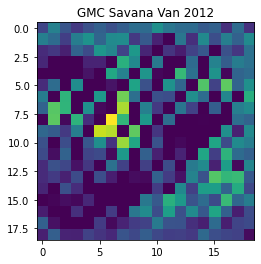

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


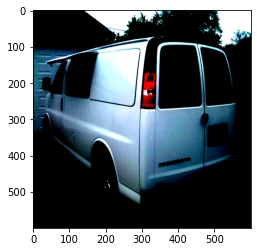

In [72]:
# Prepare image
idx = np.random.choice(len(test_img))
img = test_img[idx]

last_conv_layer_name = 'top_conv'

classifier_layer_names = [
    "global_average_pooling2d",
    "dense",
]

# Generate class activation heatmap
heatmap = make_gradcam_heatmap(
    np.expand_dims(img, axis=0), model, last_conv_layer_name, classifier_layer_names
)

# Display heatmap
plt.title(test_label[idx])
plt.imshow(heatmap);
plt.show()
plt.imshow(img)

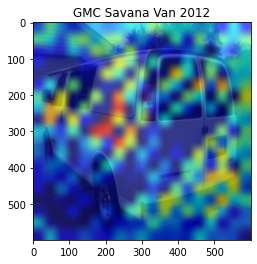

In [73]:
# We rescale heatmap to a range 0-255
heatmap = np.uint8(255 * heatmap)

# We use jet colormap to colorize heatmap
jet = cm.get_cmap("jet")

# We use RGB values of the colormap
jet_colors = jet(np.arange(256))[:, :3]
jet_heatmap = jet_colors[heatmap]

# We create an image with RGB colorized heatmap
jet_heatmap = tf.keras.preprocessing.image.array_to_img(jet_heatmap)
jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
jet_heatmap = tf.keras.preprocessing.image.img_to_array(jet_heatmap)

# Superimpose the heatmap on original image
superimposed_img = jet_heatmap * 0.03 + img
superimposed_img = tf.keras.preprocessing.image.array_to_img(superimposed_img)


# Display Grad CAM
plt.title(test_label[idx])
plt.imshow(superimposed_img);